### Yolov8 vs Yolov5

#### Lets compare two Yolo series models and find out which would be better for deployment, assuming both have similar evaluation metrics.

In [314]:
# Import libraries
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
from ultralytics import YOLO
import os
import cv2

In [177]:
# YOLOv5 PyTorch HUB Inference
yolov5_model = torch.hub.load('ultralytics/yolov5', 'yolov5n', force_reload=True, trust_repo=True)  # yolov5-l
im = 'images/highway.jpg'  # file
results = yolov5_model(im, size=640)  # inference
results.print()

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /home/angel/.cache/torch/hub/master.zip
YOLOv5 🚀 2024-1-20 Python-3.8.16 torch-2.0.0+cu117 CUDA:0 (NVIDIA GeForce RTX 3060, 12044MiB)

Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients
Adding AutoShape... 
image 1/1: 472x655 36 cars, 3 trucks
Speed: 3.6ms pre-process, 4.7ms inference, 1.0ms NMS per image at shape (1, 3, 480, 640)


In [178]:
# YOLOv8
# Load a model
yolov8_model = YOLO('yolov8n.pt')  # load a pretrained model

# Use the model
results = yolov8_model(im, imgsz=640)  # inference


image 1/1 /home/angel/computer_vision/production_challenge/images/highway.jpg: 480x640 40 cars, 3 trucks, 4.8ms
Speed: 1.5ms preprocess, 4.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


##### Profiler function leverage with ultralytics api

In [209]:
def profile_yolov8(img, iters=1000, size=640):
    results = {'preprocess': [],
                'inference': [],
                'postprocess': []}
    # warmup
    for i in range(0, 10):
        yolov8_results = yolov8_model(img, imgsz=size, verbose=False) # inference
    # profile preprocess, inference and postprocess
    for i in range(0, iters):
        yolov8_results = yolov8_model(img, imgsz=size, verbose=False) # inference
        s = yolov8_results[0].speed
        results['preprocess'].append(s['preprocess'])
        results['inference'].append(s['inference'])
        results['postprocess'].append(s['postprocess'])
        
    return results

In [210]:
def profile_yolov5(img, iters=1000, size=640):
    results = {'preprocess': [],
                'inference': [],
                'postprocess': []}
    # warmup
    for i in range(0, 10):
        yolov5_results = yolov5_model(im, size=640)  # inference
    # profile preprocess, inference and postprocess
    for i in range(0, iters):
        yolov5_results = yolov5_model(im, size=640)  # inference
        pre, inf, post = yolov5_results.tolist()[0].t
        results['preprocess'].append(pre)
        results['inference'].append(inf)
        results['postprocess'].append(post)
        
    return results

In [224]:
yolov8_list_res = profile_yolov8(img=im)
yolov5_list_res = profile_yolov5(img=im)

#### Plot Results

In [298]:
def plot_speed_metrics(src_1, src_2, names=['yolov8', 'yolov5'], key='inference', show=True, save=False):
    data_1 = np.array(src_1[key])
    data_2 = np.array(src_2[key])

    data = [data_1, data_2]

    fig = plt.figure(figsize =(10, 7))
    ax = fig.add_subplot(111)

    # Creating axes instance
    bp = ax.boxplot(data, patch_artist = True,
                    notch ='True', vert = 0)

    colors = ['#0000FF', '#00FF00', 
            '#FFFF00', '#FF00FF']

    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    # changing color and linewidth of
    # whiskers
    for whisker in bp['whiskers']:
        whisker.set(color ='#8B008B',
                    linewidth = 1.5,
                    linestyle =":")

    # changing color and linewidth of
    # caps
    for cap in bp['caps']:
        cap.set(color ='#8B008B',
                linewidth = 2)

    # changing color and linewidth of
    # medians
    for median in bp['medians']:
        median.set(color ='red',
                linewidth = 3)

    # changing style of fliers
    for flier in bp['fliers']:
        flier.set(marker ='D',
                color ='#e7298a',
                alpha = 0.5)
        
    # x-axis labels
    ax.set_yticklabels([names[0], names[1]])

    # Adding title 
    plt.title(key.capitalize())

    # Removing top axes and right axes
    # ticks
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    mu_1 = data_1.mean()
    mu_2 = data_2.mean()
    textstr = '\n'.join((
        r'$\mu :%s=%.2f$ ms' % (names[0], mu_1, ),
        r'$\mu :%s=%.2f$ ms' % (names[1], mu_2, )))
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(0.72, 0.88, textstr, transform=ax.transAxes, fontsize=14, bbox=props)
        
    # show plot
    if show:
        plt.show()
    if save:
        path = os.path.join("images",key+".png")
        fig.savefig(path)
        
    return {names[0]:mu_1, names[1]:mu_2}

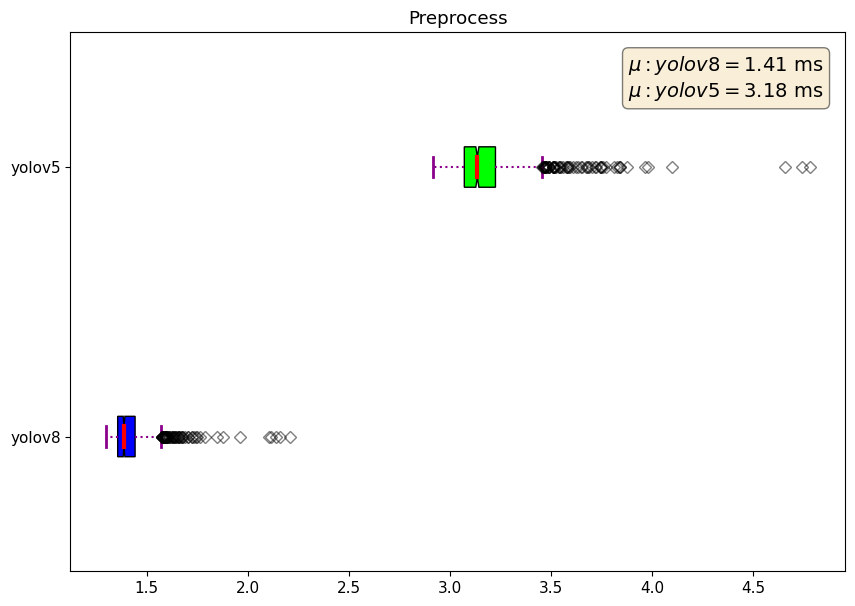

{'yolov8': 1.4149408340454102, 'yolov5': 3.1782989501953125}

In [301]:
# preprocess plot
plot_speed_metrics(yolov8_list_res, yolov5_list_res, key='preprocess', show=True, save=True)

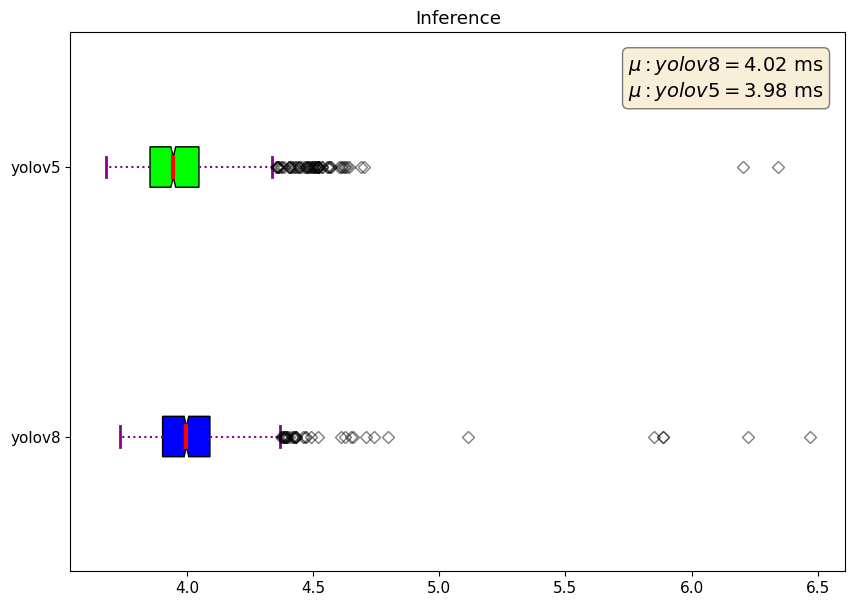

{'yolov8': 4.021538496017456, 'yolov5': 3.978715181350708}

In [300]:
# inference plot
plot_speed_metrics(yolov8_list_res, yolov5_list_res, key='inference', show=True, save=True)

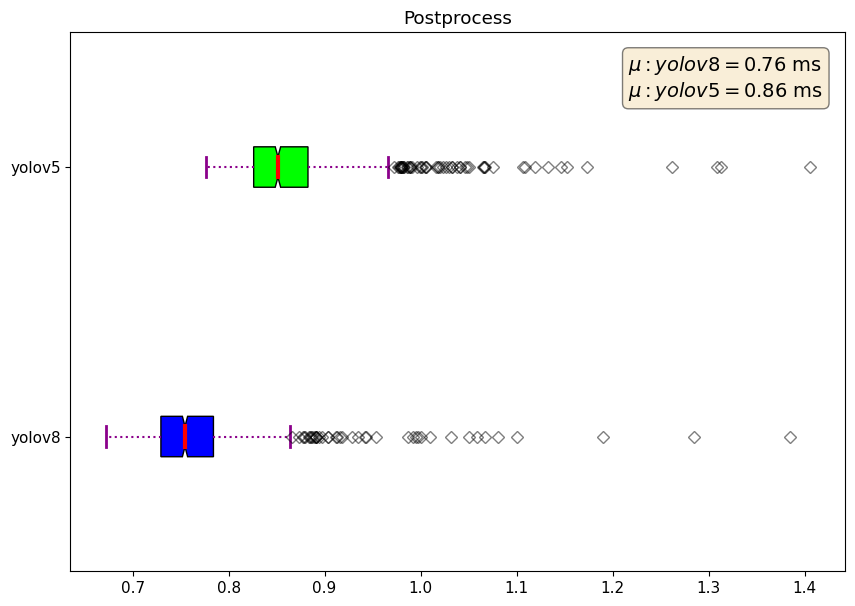

{'yolov8': 0.7629940509796143, 'yolov5': 0.8629152774810791}

In [302]:
plot_speed_metrics(yolov8_list_res, yolov5_list_res, key='postprocess', show=True, save=True)

#### Optimization

In [398]:
# Export the model
yolov8_model.export(format='onnx', imgsz=(640,480),half=True, simplify=True, opset=13, device=0)

Ultralytics YOLOv8.1.3 🚀 Python-3.8.16 torch-2.0.0+cu117 CUDA:0 (NVIDIA GeForce RTX 3060, 12044MiB)

PyTorch: starting from 'yolov8n.pt' with input shape (1, 3, 640, 480) BCHW and output shape(s) (1, 84, 6300) (6.2 MB)

ONNX: starting export with onnx 1.15.0 opset 13...
============= Diagnostic Run torch.onnx.export version 2.0.0+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

ONNX: simplifying with onnxsim 0.4.35...
ONNX: export success ✅ 0.5s, saved as 'yolov8n.onnx' (6.1 MB)

Export complete (0.5s)
Results saved to /home/angel/computer_vision/production_challenge
Predict:         yolo predict task=detect model=yolov8n.onnx imgsz=640,480 half 
Validate:        yolo val task=detect model=yolov8n.onnx imgsz=640,480 data=coco.yaml half WARNING ⚠️ non-PyTorch val requires square images, 'imgsz=[640, 480]' will not work. Use export 'imgsz=640' if val is required.
Visualize:       https://netron.ap

'yolov8n.onnx'

In [399]:
import onnx
import onnxruntime as ort
onnx_model = onnx.load(r"yolov8n.onnx")
onnx.checker.check_model(onnx_model)

In [408]:
providers = ['CUDAExecutionProvider']
ort_sess = ort.InferenceSession(r'yolov8n.onnx', providers=providers)
ort_sess.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_EXTENDED
input = ort_sess.get_inputs()[0].name
output = ort_sess.get_outputs()[0].name
io_binding = ort_sess.io_binding()

In [409]:
from yolo_utils import LetterBox

In [410]:
img = cv2.imread(r"images/highway.jpg")
preprocess = LetterBox(new_shape=(640,480))
prepro_img, _ = preprocess(image = img)
t_img = np.transpose(prepro_img, (2, 0, 1)).astype("float16")/255
t_img = t_img[None,:,:,:]

In [411]:
io_binding.bind_cpu_input(input, t_img)
io_binding.bind_output(output)
ort_sess.run_with_iobinding(io_binding)
Y = io_binding.copy_outputs_to_cpu()[0]

In [412]:
from time import perf_counter
import numpy as np

In [413]:
def timer(f,*args):   
    start = perf_counter()
    f.run_with_iobinding(*args)
    return (1000 * (perf_counter() - start))

In [415]:
print(f"Yolov8 ORT: {np.mean([timer(ort_sess,io_binding) for _ in range(10000)])} ms")

Yolov8 ORT: 4.2402817899666845 ms


##### TensorRT

In [417]:
from trt_infer.infer import TensorRTInfer

In [418]:
trt_infer = TensorRTInfer('yolov8n.trt')

In [419]:
prediction = trt_infer.infer(t_img)

In [424]:
def trt_timer(f,*args):   
    start = perf_counter()
    f.infer(*args)
    return (1000 * (perf_counter() - start))

In [426]:
print(f"Yolov8 TRT: {np.mean([trt_timer(trt_infer,t_img) for _ in range(10000)])} ms")

Yolov8 TRT: 2.392428541831032 ms
